In [1]:
import pawlikMorphLSST as pmlsst                    # Library for analysing galaxies
print("Galaxy analysis code imported")

# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs                 # query with CasJobs
import SciServer.SkyServer as SkyServer
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                                  # standard Python lib for math ops
import pandas as pd                                 # data manipulation package
import matplotlib.pyplot as plt                     # another graphing package
from pathlib import Path                            # manage local files in your Compute containers
from astropy.visualization import ZScaleInterval    # for plotting clear images
from tqdm import tqdm_notebook                      # for a nice progress bar
from concurrent.futures import ProcessPoolExecutor  # for running the code on more than 1 cpu
from IPython.display import clear_output            # allow nice printing
import json
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)

# for plotting clear images
zscale = ZScaleInterval()

# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Galaxy analysis code imported
SciServer libraries imported
Supporting libraries imported
Settings applied


In [2]:
# Find objects in the Sloan Digital Sky Survey's.
#
# Query the Sloan Digital Sky Serveys' NSA catalog of galactical objects.
# For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx?cmd=description+nsatlas+U#&&history=description+nsatlas+U
#
# This query finds all galaxies in the value added catalogue PawlikMorph and matches this information to the
# MaNGA catalogue in order to get galaxies positions.
# Finally we discard any galaxies that have incomplete measurments
#
# First, store the query in an object called "query"
query="""
select distinct m.objra, m.objdec, p.run, p.rerun, p.camcol, p.field, p.S, p.R20, p.R80
from dbo.PawlikMorph p
  join dbo.mangaDAPall m
  on m.mangaID = p.mangaid
"""

#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")
print(f"SQL query returned {len(all_gals.index)} galaxies")

SQL query finished.
SQL query returned 4603 galaxies


In [4]:
# add a column to the dataframe, which contains the path to the image
def makename(df):
    root = "/home/idies/workspace/sdss_das/das2/imaging/"
    df["fname"] = df.apply(lambda row: root + f"{int(row.run)}/{int(row.rerun)}/corr/{int(row.camcol)}/fpC-{int(row.run):06}-r{int(row.camcol)}-{int(row.field):04}.fit.gz", axis=1)
    return df

# add filename column
all_gals = makename(all_gals)
# View the information of the first 10 galaxies retrieved
all_gals[0:10]

,objra,objdec,run,rerun,camcol,field,S,R20,R80,fname
0,27.475456,13.126633,1035,40,2,144,0.049302,4.143,17.220,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
1,27.529863,13.110374,1035,40,2,144,0.096871,3.334,15.406,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
2,27.565306,13.140773,1035,40,2,144,0.115196,2.971,11.520,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
3,27.653662,13.110200,1035,40,2,145,0.155478,1.701,52.690,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0145.fit.gz
4,27.842783,13.060335,1035,40,2,146,0.172169,1.551,41.625,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0146.fit.gz
5,27.886442,12.699600,1035,40,1,147,0.281075,6.779,31.605,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/1/fpC-001035-r1-0147.fit.gz
6,28.079226,13.634056,1035,40,3,147,0.070220,6.191,33.866,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/3/fpC-001035-r3-0147.fit.gz
7,28.185047,13.192551,1035,40,2,148,0.089205,5.205,21.277,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0148.fit.gz
8,28.375704,14.570949,1043,40,5,185,-99.000000,6.187,29.026,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/5/fpC-001043-r5-0185.fit.gz
9,28.443092,12.880449,1043,40,1,186,0.131965,5.326,35.598,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/1/fpC-001043-r1-0186.fit.gz


In [5]:
# This snippet create a list of filenames, and positions that analyseImage requires to run
info = []
for i in range(0, len(all_gals.index)):
    ra, dec = all_gals["objra"].iloc[i], all_gals["objdec"].iloc[i]
    name = all_gals["fname"].iloc[i]
    info.append([name, ra, dec])

In [6]:
def processResult(results):
    processedResults = {"A": [], "As": [], "As90": [], "C": [], "S": [], "g": [], "m20": [], "fname": [], "radec": []}
    for result in results:
        if result[0] != -99:
            processedResults["A"].append(result[0])
            processedResults["As"].append(result[1])
            processedResults["As90"].append(result[2])
            processedResults["C"].append(result[3])
            processedResults["S"].append(result[4])
            processedResults["g"].append(result[5])
            processedResults["m20"].append(result[6])
            processedResults["fname"].append(result[7])
            processedResults["radec"].append((result[8], result[9]))
    return processedResults

In [7]:
cores = 16
results = []
with ProcessPoolExecutor(max_workers=cores) as pool:
    for result in tqdm_notebook(pool.map(pmlsst.helpers.analyseImage, info), total=len(info)):
        results.append(result)
finalResults = processResult(results)
json.dump(finalResults, open("results.json", "w"))

If your code crashes, or this work is completed over more than one afternoon, you can reload the results using the below code in order to save time.

In [ ]:
finalResults = json.load(open("results.json"))

In [ ]:
from photutils import CircularAperture, CircularAnnulus
import scipy.ndimage as ndi

row = all_gals.iloc[3021]
img = pmlsst.image.readImage("sdss", filename=row["fname"], ra=row["objra"], dec=row["objdec"])
img = pmlsst.imageutils.maskstarsSEG(img)
skybgr, skybgr_err, *_ = pmlsst.skyBackground.skybgr(img)
mask = pmlsst.pixmap.pixelmap(img, skybgr + skybgr_err, 3)

# subtract sky
img -= skybgr

# Rmax = pmlsst.pixmap.calcRmax(img, mask)
# aperturepixmap = pmlsst.apertures.aperpixmap(img.shape[0], Rmax, 9, 0.1)

# starmask = np.ones_like(img)
# apix = pmlsst.asymmetry.minapix(img, mask, aperturepixmap, starmask)

# r20, r80 = pmlsst.casgm.calcR20_R80(img, apix, Rmax)
# r_in = r80
# r_out = Rmax
# centroid = apix
# # Exclude inner 20% of light. See Concelice 2003
# imageApeture = CircularAnnulus(centroid, r_in, r_out)

# # smooth image
# imageSmooth = ndi.uniform_filter(img, size=int(r20))

# # calculate residual, setting any negative pixels to 0.
# imageDiff = img - imageSmooth
# imageDiff[imageDiff < 0.] = 0.

# # calculate S, accounting for the background smoothness.
# imageFlux = imageApeture.do_photometry(img, method="exact")[0][0]
# diffFlux = imageApeture.do_photometry(imageDiff, method="exact")[0][0]
# backgroundSmooth = _getBackgroundSmoothness(img, mask, sky, r20)
# S = (diffFlux - imageApeture.area*backgroundSmooth) / imageFlux


C, S, gini, m20 = pmlsst.casgm.calculateCSGM(img, mask, skybgr)
#print(S)
print(row)
print(S, r20, r80)

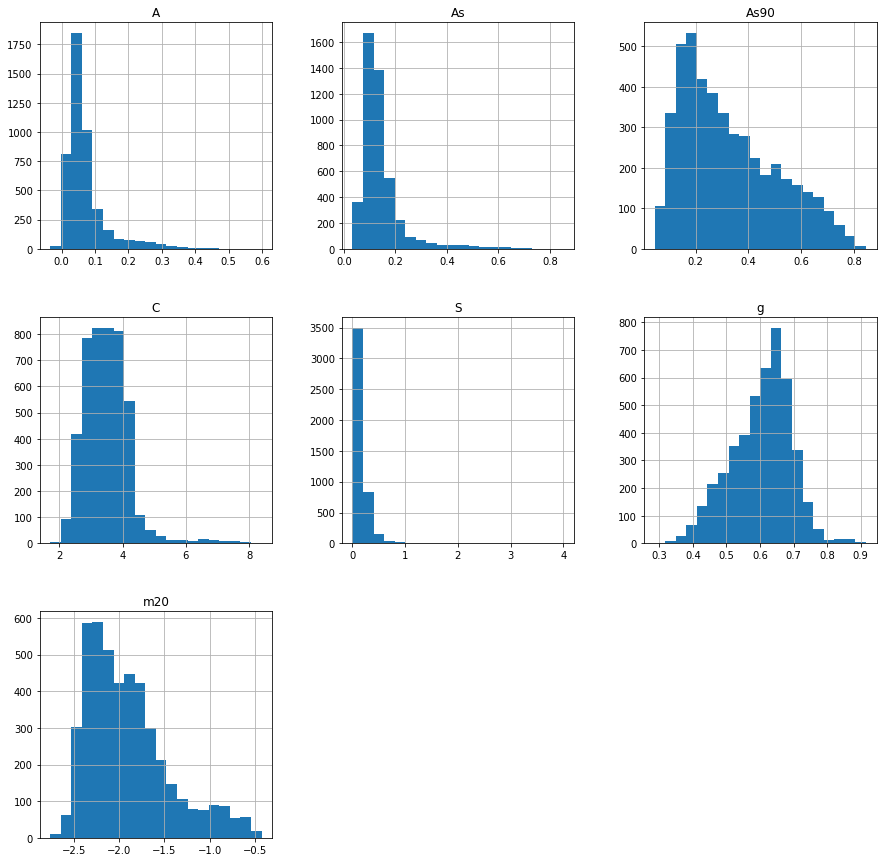

In [11]:
df = pd.DataFrame.from_dict(finalResults)
hist = df.hist(bins=20, figsize=(15,15))

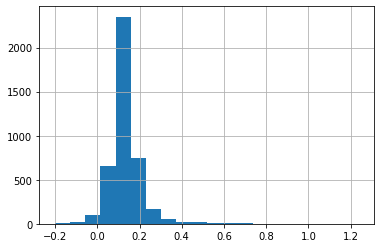

In [9]:
all_gals = all_gals[all_gals.S != -99]
hist2 = all_gals["S"].hist(bins=20)

In [ ]:
from astropy import wcs
mergers = df.query("C >= 4.")
print(len(mergers.index))
imgs = mergers.iloc[:16]

fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
for i in range(len(imgs.index)):
    filename = imgs["fname"].iloc[i]
    ra, dec = imgs["radec"].iloc[i]
    image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)
    image = pmlsst.imageutils.maskstarsSEG(image)

    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")

In [ ]:
import SciServer.SkyServer as SkyServer
mergers = all_gals.query("As >= 0.2")
fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
pixelsize=.369
for i in range(16):
    filename = mergers["fname"].iloc[i]
    ra, dec = mergers["objra"].iloc[i], mergers["objdec"].iloc[i]
    #image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)
    #image = pmlsst.imageutils.maskstarsSEG(image)
#     scale = 2.*mergers["rmax"]/pixelsize/200
#     print(scale)
    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=200, height=200, scale=.3, dataRelease='DR16')
    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")